In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from src.model_specpred import SpectrumPredictor
from src.utils_model import lorentzian, spec_to_Sqt, batch_spec_to_Sqt

from matplotlib.colors import to_rgb, to_rgba

from matplotlib.colors import Normalize
from scipy.interpolate import interp1d
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

torch.set_default_dtype(torch.float64)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

c:\Users\zhant\.conda\envs\sqt\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import seaborn
palette_crest = seaborn.color_palette(palette='crest')
palette_flare = seaborn.color_palette(palette='flare')

In [3]:
model_spec = SpectrumPredictor.load_from_checkpoint("production_models/version_large_training_set/checkpoints/epoch=8456-step=422850.ckpt")

In [4]:
data = torch.load("data/CrI3/20221110.pt")
X = data['param'][:,:2]
Y = torch.cat((data['omega'], data['inten']), dim=1)

indices_dict = torch.load("data_splitting/indices_42_800-100-100.pt")
train_indices = indices_dict['train']
val_indices = indices_dict['val']
test_indices = indices_dict['test']

X_train = X[train_indices]
Y_train = Y[train_indices]
train_dataset = TensorDataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

X_test = X[test_indices]
Y_test = Y[test_indices]

print("print some values for further reference:")
# print("training:\n", X_train[:5])
# print("validation:\n", X_val[:5])
print("testing:\n", X_test[:5])

print some values for further reference:
testing:
 tensor([[-1.5924e+00, -2.1911e-01],
        [-2.9503e+00, -8.5994e-04],
        [-1.6105e+00, -2.4190e-01],
        [-2.3308e+00, -4.2538e-01],
        [-1.8445e+00, -5.6670e-01]])


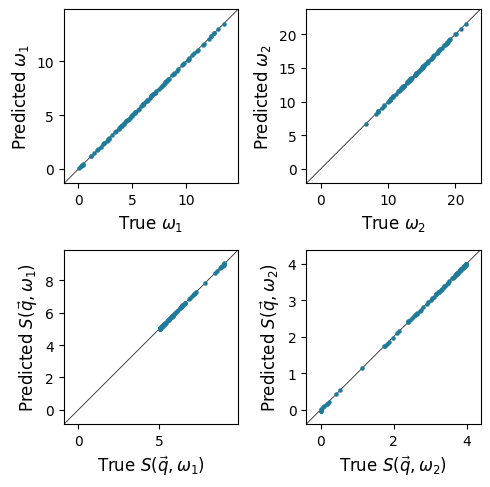

In [5]:
model_spec.to(device)

loss_test = []
Y_test_pred = []
with torch.no_grad():
    for x_test, y_test in zip(X_test, Y_test):
        y_test_pred = model_spec(x_test.to(device)).detach().cpu()
        loss_test.append((y_test_pred - y_test).abs().mean().item())
        Y_test_pred.append(y_test_pred)
Y_test_pred = torch.vstack(Y_test_pred)

labels = [r'$\omega_1$', r'$\omega_2$', r'$S(\vec{q},\omega_{1})$', r'$S(\vec{q},\omega_{2})$']

fig = plt.figure(figsize=(5,5))
gs = plt.GridSpec(2,2)
for i in range(4):
    ax = fig.add_subplot(gs[i])
    ax.plot([-100,100], [-100,100], 'k', linewidth=0.5, zorder=0)
    ax.scatter(Y_test[:,i], Y_test_pred[:,i], s=5, color="#207A9A", zorder=10)
    ax.set_aspect('equal')
    ax.set_xlim([-0.1*Y_test[:,i].max(), 1.1*Y_test[:,i].max()])
    ax.set_ylim([-0.1*Y_test[:,i].max(), 1.1*Y_test[:,i].max()])
    ax.set_xlabel(f"True {labels[i]}", fontsize=12)
    ax.set_ylabel(f"Predicted {labels[i]}", fontsize=12)

fig.tight_layout()
# fig.savefig("figs/paper/network_hist2d.pdf", bbox_inches='tight')

In [6]:
def read_pkl_data(fname):
    with open(fname, 'rb') as f:
        data_dict = pickle.load(f)
    loss_abs = np.abs(data_dict['param_mean'] - data_dict['param_true'][:,None,:])
    loss_rel = (np.abs(data_dict['param_mean'] - data_dict['param_true'][:,None,:])) / np.abs(data_dict['param_true'][:,None,:])
    return loss_abs, loss_rel

def read_pkl_data_for_dict(fname):
    with open(fname, 'rb') as f:
        data_dict = pickle.load(f)
    param_mean = []
    param_true = []
    for idx in data_dict.keys():
        param_mean.append(data_dict[idx]['param_mean'][None])
        param_true.append(data_dict[idx]['param_true'][None])
    param_mean = np.vstack(param_mean)
    param_true = np.vstack(param_true)
    loss_abs = np.abs(param_mean - param_true[:,None,:])
    loss_rel = (np.abs(param_mean - param_true[:,None,:])) / np.abs(param_true[:,None,:])
    # loss_abs = np.abs(data_dict['param_mean'] - data_dict['param_true'][:,None,:])
    # loss_rel = (np.abs(data_dict['param_mean'] - data_dict['param_true'][:,None,:])) / np.abs(data_dict['param_true'][:,None,:])
    return loss_abs, loss_rel

In [7]:
noise_level = 10.0
pw = 0.2
datadir = 'benchmarks'
# datadir = '/pscratch/sd/z/zhantao/BayesExpSteering/benchmarks'

task_labels = ['gd', 'baseline', 'sequential', 'random']
run_labels = ['RUN_1', 'RUN_2', 'RUN_3', 'RUN_4']
fname_lst = [
    os.path.join(datadir, f'{run}/bayesian_{task}_pw-{pw}_nl-{noise_level}_Nb-100.pkl') for task in task_labels for run in run_labels
]

print('\n'.join(fname_lst))

benchmarks\RUN_1/bayesian_gd_pw-0.2_nl-10.0_Nb-100.pkl
benchmarks\RUN_2/bayesian_gd_pw-0.2_nl-10.0_Nb-100.pkl
benchmarks\RUN_3/bayesian_gd_pw-0.2_nl-10.0_Nb-100.pkl
benchmarks\RUN_4/bayesian_gd_pw-0.2_nl-10.0_Nb-100.pkl
benchmarks\RUN_1/bayesian_baseline_pw-0.2_nl-10.0_Nb-100.pkl
benchmarks\RUN_2/bayesian_baseline_pw-0.2_nl-10.0_Nb-100.pkl
benchmarks\RUN_3/bayesian_baseline_pw-0.2_nl-10.0_Nb-100.pkl
benchmarks\RUN_4/bayesian_baseline_pw-0.2_nl-10.0_Nb-100.pkl
benchmarks\RUN_1/bayesian_sequential_pw-0.2_nl-10.0_Nb-100.pkl
benchmarks\RUN_2/bayesian_sequential_pw-0.2_nl-10.0_Nb-100.pkl
benchmarks\RUN_3/bayesian_sequential_pw-0.2_nl-10.0_Nb-100.pkl
benchmarks\RUN_4/bayesian_sequential_pw-0.2_nl-10.0_Nb-100.pkl
benchmarks\RUN_1/bayesian_random_pw-0.2_nl-10.0_Nb-100.pkl
benchmarks\RUN_2/bayesian_random_pw-0.2_nl-10.0_Nb-100.pkl
benchmarks\RUN_3/bayesian_random_pw-0.2_nl-10.0_Nb-100.pkl
benchmarks\RUN_4/bayesian_random_pw-0.2_nl-10.0_Nb-100.pkl


In [8]:
with open(fname_lst[0], 'rb') as f:
    data_dict = pickle.load(f)

In [9]:
sample_idx = 2

param_true = data_dict[sample_idx]['param_true']
measurement_settings = data_dict[sample_idx]['measurement_settings']
measurements = data_dict[sample_idx]['measurements']

In [10]:
%load_ext autoreload
%autoreload 2

from src.utils_gd import fit_measurement_with_OptBayesExpt_parameters, get_I_from_params

In [11]:
param_true

array([-1.61049561, -0.24190072,  0.1       ])

In [16]:
t = torch.from_numpy(measurement_settings).squeeze()
S = torch.from_numpy(measurements).squeeze()

loss_hist, params_hist = fit_measurement_with_OptBayesExpt_parameters(
    model_spec, t, S, 
    (('J', 'D', 'gamma'), param_true, (0.05,0.05, 0.05)), 
    pulse_width=pw, norm_I0=100,
    lr=0.025, maxiter=10, batch_size=10, model_uncertainty=False, verbose=True, device='cuda'
)

# loss_hist, params_hist = fit_measurement_with_OptBayesExpt_parameters(
#     model_spec, t, S, 
#     (('J', 'D', 'gamma'), particles_init, (None, None, None)), 
#     pulse_width=pw, norm_I0=100, params_type='particles',
#     lr=0.025, maxiter=1000, batch_size=len(particles_init[0]), model_uncertainty=False, verbose=True, device='cuda'
# )

 10%|█         | 1/10 [00:00<00:02,  3.35it/s]c:\Users\zhant\Dropbox\SLAC\research\TopologicalSpinML\topo-spin-Sqt-ML-main\src\utils_gd.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pulse_width = torch.tensor(pulse_width).to(y).clone().detach()
100%|██████████| 10/10 [00:01<00:00,  7.45it/s]


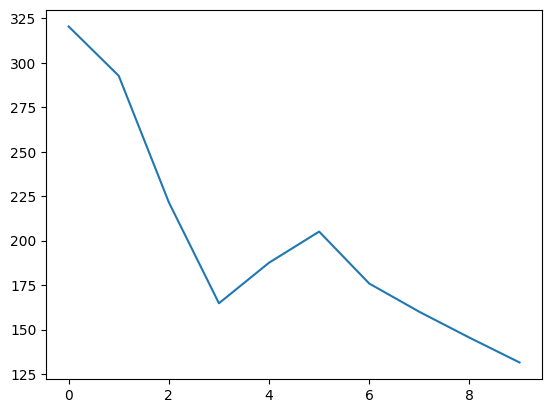

In [17]:
plt.plot(loss_hist)

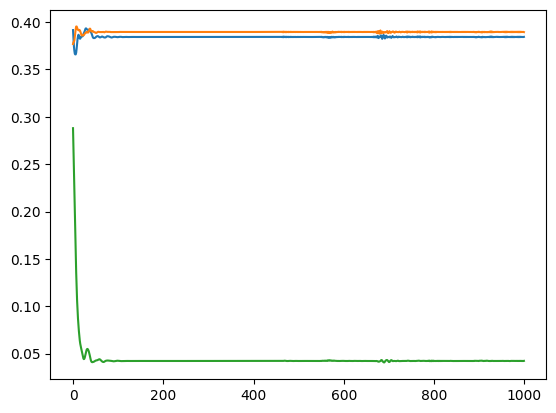

In [90]:
plt.plot((params_hist['J'].mean(axis=1) - param_true[0]).abs())
plt.plot((params_hist['D'].mean(axis=1) - param_true[1]).abs())
plt.plot((params_hist['gamma'].mean(axis=1) - param_true[2]).abs())

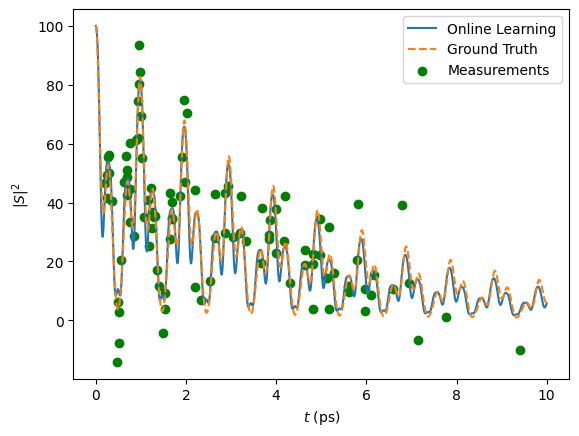

In [86]:
from src.utils_model import array2tensor
times = torch.linspace(0,10,1001)
particles_init = torch.nn.ParameterDict({k: array2tensor(p.reshape(-1,1)) for k, p in zip(("J", "D", "gamma"), data_dict[sample_idx]['particles'][-1])})
particles_true = torch.nn.ParameterDict({k: array2tensor(p.reshape(-1,1)) for k, p in zip(("J", "D", "gamma"), data_dict[sample_idx]['param_true'])})
I_pred = get_I_from_params(model_spec, times, particles_init, pulse_width=pw, device=device).squeeze(1).detach().cpu().numpy()
I_true = get_I_from_params(model_spec, times, particles_true, pulse_width=pw, device=device).squeeze(1).detach().cpu().numpy()

fig, ax = plt.subplots(1,1)
ax.plot(times, np.mean(I_pred, axis=0), label="Online Learning")
ax.plot(times, np.mean(I_true, axis=0), '--', label="Ground Truth")
ax.scatter(measurement_settings, measurements, label="Measurements", c='g')
ax.set_xlabel('$t$ (ps)')
ax.set_ylabel('$|S|^{2}$')
ax.legend()

In [11]:
for task in task_labels:
    for run in run_labels:
        print(f"collecting {task}-{run}")

collecting gd-RUN_1
collecting gd-RUN_2
collecting gd-RUN_3
collecting gd-RUN_4
collecting gd-RUN_5
collecting baseline-RUN_1
collecting baseline-RUN_2
collecting baseline-RUN_3
collecting baseline-RUN_4
collecting baseline-RUN_5
collecting sequential-RUN_1
collecting sequential-RUN_2
collecting sequential-RUN_3
collecting sequential-RUN_4
collecting sequential-RUN_5
collecting random-RUN_1
collecting random-RUN_2
collecting random-RUN_3
collecting random-RUN_4
collecting random-RUN_5


In [24]:
index = torch.arange(4).repeat_interleave(5)
print(index)

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3])


In [25]:
loss_info_lst = loss_abs

In [26]:
torch.tensor(np.asarray(loss_info_lst)).shape

torch.Size([20, 100, 200, 3])

In [27]:
import torch_scatter

loss = torch.tensor(np.asarray(loss_info_lst))
loss_exp_mean = torch_scatter.scatter_mean(loss, index, dim=0)
loss_mean = loss_exp_mean.mean(dim=1)
loss_std = torch_scatter.scatter_std(loss, index, dim=0).mean(dim=1)

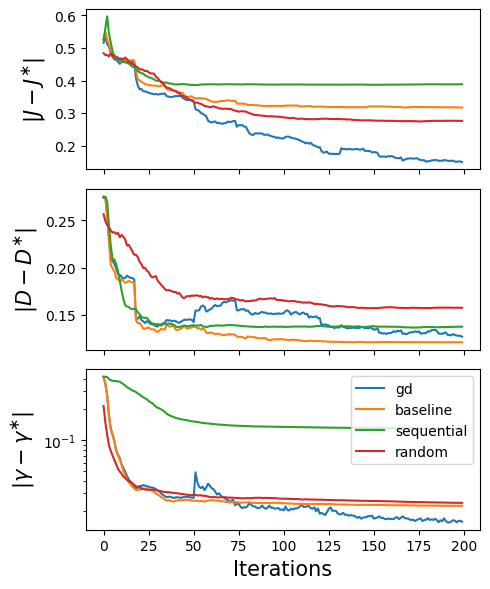

In [28]:
ylabels = ['J', 'D', '\gamma']

fig, ax = plt.subplots(3, 1, figsize=(5,6), sharex=True)
for i_ax in range(3):
    for i, (_mean, _std) in enumerate(zip(loss_mean, loss_std)):
        ax[i_ax].plot(np.arange(_mean.shape[0]), _mean[...,i_ax])
        # ax[i_ax].fill_between(np.arange(_mean.shape[0]), _mean[...,i_ax]-_std[...,i_ax], _mean[...,i_ax]+_std[...,i_ax], alpha=0.25)
    ax[i_ax].set_ylabel(rf'$|{ylabels[i_ax]}-{ylabels[i_ax]}^{{\ast}}|$', fontsize=15)
ax[-1].set_xlabel('Iterations', fontsize=15)
ax[-1].legend(task_labels)
ax[-1].set_yscale('log')
fig.tight_layout()
# fig.savefig(f"figs/paper/comparisons/pw-{pw}_nl-{noise_level}_Nb-200.pdf", bbox_inches='tight')

IndexError: list index out of range

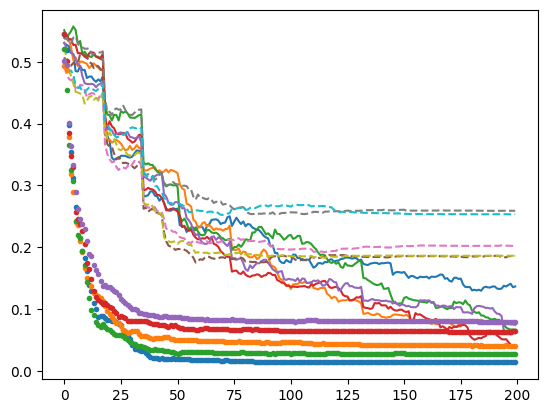

In [21]:
idx = 0
linestyles = ['-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '.', '.', '.', '.', '.']
# linestyles = ['-', '-', '--', '--', '.', '.']
fig, ax = plt.subplots(1, 1)
for i, _loss in enumerate(loss_info_lst):
    ax.plot(np.arange(_loss.shape[1]), _loss.mean(axis=0)[:,idx], linestyles[i])
    # ax.fill_between(np.arange(loss.shape[1]), 
    #     loss.mean(axis=0)[:,idx]-0.05*loss.std(axis=0)[:,idx],
    #     loss.mean(axis=0)[:,idx]+0.05*loss.std(axis=0)[:,idx], alpha=0.25)

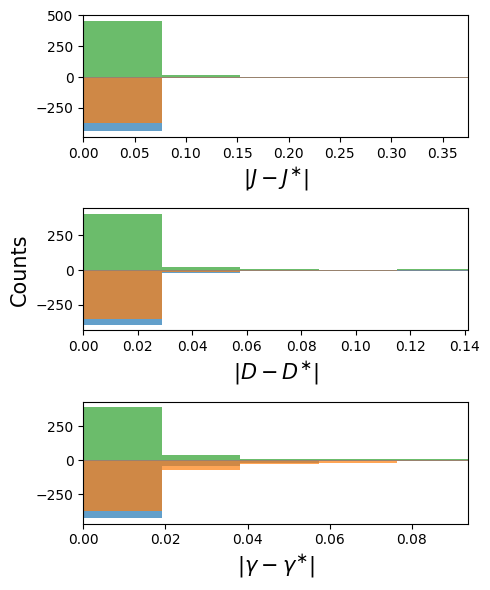

In [22]:
i_iter = -1

xlabels = ['J', 'D', '\gamma']

fig, ax = plt.subplots(3, 1, figsize=(5,6))
for i_ax in range(3):
    bins = np.linspace(0, loss[...,i_ax].max(), 50)
    for i_param in range(3):
        data = torch.cat(torch.unbind(loss[index==i_param], dim=0)).numpy()
        counts, bins = np.histogram(data[:,i_iter,i_ax], bins=bins)
        if i_param == 2:
            ax[i_ax].bar((bins[:-1]+bins[1:])/2, counts, width=bins[1]-bins[0], alpha=0.7)
        else:
            ax[i_ax].bar((bins[:-1]+bins[1:])/2, -counts, width=bins[1]-bins[0], alpha=0.7)
        # ax[i_ax].set_yscale('log')
    ax[i_ax].hlines(0, -10, 10, colors='gray', linestyles='-', linewidth=0.5)
    ax[i_ax].set_xlabel(rf'$|{xlabels[i_ax]}-{xlabels[i_ax]}^{{\ast}}|$', fontsize=15)
    ax[i_ax].set_xlim([0, 0.1 * loss[...,i_ax].max()])
    # ax[i_ax].set_yticks([-300,  0, 300])
    if i_ax == 1:
        ax[i_ax].set_ylabel('Counts', fontsize=15)
    # ax[i_ax].set_yticklabels(['-500', '0', '500'])
fig.tight_layout()
# fig.savefig(f"figs/paper/comparisons/hist_pw-{pw}_nl-{noise_level}_Nb-200.pdf", bbox_inches='tight')

(-1.0, 3.0)

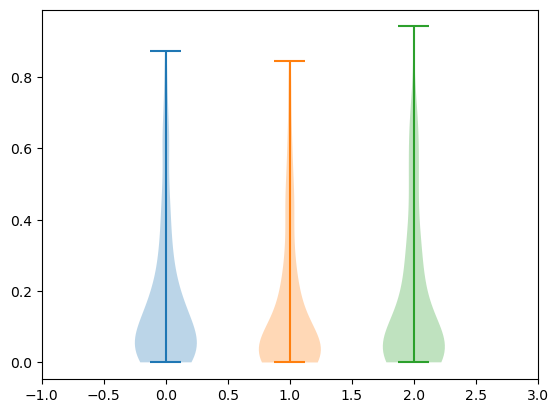

In [6]:
import seaborn as sns

idx = 1
iter_num = 10

fig = plt.figure()
ax = fig.add_subplot()
ax.violinplot(loss_info_lst[0][:,iter_num,idx], positions=[0])
ax.violinplot(loss_info_lst[4][:,iter_num,idx], positions=[1])
ax.violinplot(loss_info_lst[-1][:,iter_num,idx], positions=[2])
# sns.swarmplot(x=0*np.ones_like(loss_info_lst[0][:,iter_num,idx]), y=loss_info_lst[0][:,iter_num,idx], orient='v')
# sns.swarmplot(x=1*np.ones_like(loss_info_lst[4][:,iter_num,idx]), y=loss_info_lst[4][:,iter_num,idx], orient='v')
# sns.swarmplot(x=2*np.ones_like(loss_info_lst[-1][:,iter_num,idx]), y=loss_info_lst[-1][:,iter_num,idx], orient='v')
ax.set_xlim([-1, 3])
# ax.set_yscale('log')

In [7]:
with open('{datadir}/bayesian_baseline_pw-0.1_nl-5.0_Nb-200.pkl', 'rb') as f:
    baseline_dict = pickle.load(f)
# with open('{datadir}/bayesian_baseline_pw-0.1_nl-10.0_Nb-200.pkl', 'rb') as f:
#     baseline_dict_nl10 = pickle.load(f)
with open('{datadir}/bayesian_random_pw-0.1_nl-5.0_Nb-200.pkl', 'rb') as f:
    random_dict = pickle.load(f)
with open('{datadir}/bayesian_gradientdesc_pw-0.1_nl-5.0_Nb-200.pkl', 'rb') as f:
    gd_dict = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'data/benchmark/bayesian_baseline_pw-0.1_nl-5.0_Nb-200.pkl'

In [ ]:
l1_diff_baseline = np.abs(baseline_dict['param_mean'] - baseline_dict['param_true'][:,None,:])
# l1_diff_baseline_nl10 = np.abs(baseline_dict_nl10['param_mean'] - baseline_dict_nl10['param_true'][:,None,:])
l1_diff_random = np.abs(random_dict['param_mean'] - random_dict['param_true'][:,None,:])
l1_diff_gd = np.abs(gd_dict['param_mean'] - gd_dict['param_true'][:,None,:])

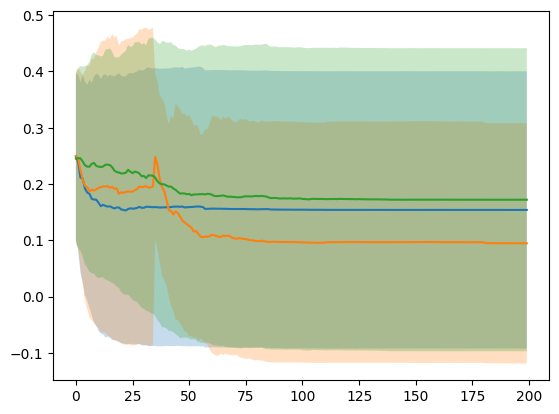

In [ ]:
idx = 1

fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(l1_diff_baseline.shape[1]), l1_diff_baseline.mean(axis=0)[:,idx])
ax.fill_between(np.arange(l1_diff_baseline.shape[1]), 
    l1_diff_baseline.mean(axis=0)[:,idx]-l1_diff_baseline.std(axis=0)[:,idx],
    l1_diff_baseline.mean(axis=0)[:,idx]+l1_diff_baseline.std(axis=0)[:,idx], alpha=0.25)

# ax.plot(np.arange(l1_diff_baseline_nl10.shape[1]), l1_diff_baseline_nl10.mean(axis=0)[:,idx])
# ax.fill_between(np.arange(l1_diff_baseline_nl10.shape[1]), 
#     l1_diff_baseline_nl10.mean(axis=0)[:,idx]-l1_diff_baseline_nl10.std(axis=0)[:,idx],
#     l1_diff_baseline_nl10.mean(axis=0)[:,idx]+l1_diff_baseline_nl10.std(axis=0)[:,idx], alpha=0.25)

ax.plot(np.arange(l1_diff_gd.shape[1]), l1_diff_gd.mean(axis=0)[:,idx])
ax.fill_between(np.arange(l1_diff_gd.shape[1]), 
    l1_diff_gd.mean(axis=0)[:,idx]-l1_diff_gd.std(axis=0)[:,idx],
    l1_diff_gd.mean(axis=0)[:,idx]+l1_diff_gd.std(axis=0)[:,idx], alpha=0.25)

ax.plot(np.arange(l1_diff_random.shape[1]), l1_diff_random.mean(axis=0)[:,idx])
ax.fill_between(np.arange(l1_diff_random.shape[1]), 
    l1_diff_random.mean(axis=0)[:,idx]-l1_diff_random.std(axis=0)[:,idx],
    l1_diff_random.mean(axis=0)[:,idx]+l1_diff_random.std(axis=0)[:,idx], alpha=0.25)